In [13]:
import pandas as pd
import matplotlib.pyplot as plt
css1 = pd.read_csv('density=0.01.csv')
css1.head()
css1.shape

(972, 46)

In [2]:
css1.columns

Index(['timestep', 'agent_0_x', 'agent_0_y', 'agent_0_orig_distance',
       'agent_1_x', 'agent_1_y', 'agent_1_orig_distance', 'agent_2_x',
       'agent_2_y', 'agent_2_orig_distance', 'agent_3_x', 'agent_3_y',
       'agent_3_orig_distance', 'agent_4_x', 'agent_4_y',
       'agent_4_orig_distance', 'agent_5_x', 'agent_5_y',
       'agent_5_orig_distance', 'agent_6_x', 'agent_6_y',
       'agent_6_orig_distance', 'agent_7_x', 'agent_7_y',
       'agent_7_orig_distance', 'agent_8_x', 'agent_8_y',
       'agent_8_orig_distance', 'agent_9_x', 'agent_9_y',
       'agent_9_orig_distance', 'agent_10_x', 'agent_10_y',
       'agent_10_orig_distance', 'agent_11_x', 'agent_11_y',
       'agent_11_orig_distance', 'agent_12_x', 'agent_12_y',
       'agent_12_orig_distance', 'gate0_x', 'gate0_y', 'gate0_orig_distance',
       'gate1_x', 'gate1_y', 'gate1_orig_distance'],
      dtype='object')

In [6]:
column_x = []
column_x.append('agent_0_x')

for i in range(1,37,3):
  i=i+3
  print(css1.columns[i])
  column_x.append(css1.columns[i])
print(column_x)

agent_1_x
agent_2_x
agent_3_x
agent_4_x
agent_5_x
agent_6_x
agent_7_x
agent_8_x
agent_9_x
agent_10_x
agent_11_x
agent_12_x
['agent_0_x', 'agent_1_x', 'agent_2_x', 'agent_3_x', 'agent_4_x', 'agent_5_x', 'agent_6_x', 'agent_7_x', 'agent_8_x', 'agent_9_x', 'agent_10_x', 'agent_11_x', 'agent_12_x']


In [7]:
nan_list = []
for x in column_x:
  nan_list.append(css1[x].isna().idxmax(1))
print(nan_list)
len(nan_list)

[879, 693, 634, 0, 806, 557, 530, 608, 485, 436, 744, 377, 321]


13

In [10]:
df_nan = pd.DataFrame(nan_list)
df_nan['agent']=df_nan.index+1
df_nan.columns=['timestep','agent']
df_nan

,timestep,agent
0,879,1
1,693,2
2,634,3
3,0,4
4,806,5
5,557,6
6,530,7
7,608,8
8,485,9
9,436,10


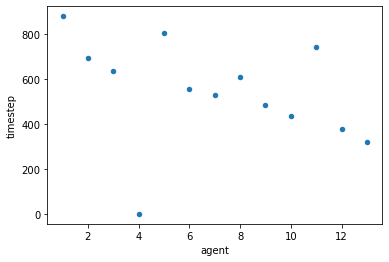

In [14]:
df_nan.plot(x='agent',y='timestep',kind='scatter')
plt.show()